In [291]:
# Numerical analysis
import numpy as np
import jax.numpy as jnp
from jax import random
from jax.nn import sigmoid

# Bayesian inference
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
import arviz as az

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Set pseudo random number key
prng_key = random.PRNGKey(1)

In [292]:
# Parameters
n_repetitions = 2
N = 200 # number of observations
D =  50 # length of true beta

<h1> Generating Data </h1>

$$\begin{align*}
Y &= X\cdot\beta \\
x_i &\sim N(0, 1) \text{ for } i = 1, ..., 400\\
\beta &= [2, -1, 0.5, 0, 0, ..., 0] \\
\end{align*}$$

In [293]:
def generate_data(A, N, D):
    assert D >= 3
    X = np.random.randn(N, D)*A
    W = np.array([2, -1, 0.5])
    Y = jnp.dot(X[:, :3], W)
    return X, Y

<h2> Defining the Model </h2>

$$\begin{align*} 
\gamma_i &= \sigma ((L_i + \log(\alpha_i)) / \lambda) \text{  for   } i = 1, ..., n \\
L_i &= \log (U_i) - \log (1-U_i)\\
U_i &\sim \text{Uniform}(0, 1)
\end{align*}$$




In order for the model to work correctly, $\alpha_i$ must be  $\in (0, \infty)$. Some choices for $\alpha_i$ could be $\sigma(y)$, $\exp (y)$, etc.


In addition, the shrinkage coefficient $\kappa_i = 1 - \gamma_i$ is recorded.

In [294]:
def model(alphas, lam, X=None, Y=None):
    '''
    Defines the Concrete random variable distribution.

    Parameters:
       real lam: temperature coefficient
       array alphas: parameter
    '''
    N, D = X.shape # NxD

    U = numpyro.sample("U", dist.Uniform(0, 1).expand([D])) #Dx1
    
    L = numpyro.deterministic("L", jnp.log(U) - jnp.log(1 - U)) #Dx1

    gammas = numpyro.deterministic("gammas", sigmoid((L + jnp.log(alphas)) / lam)) #Dx1

    kappas = numpyro.deterministic("kappas", 1 - gammas) #Dx1

    betas = numpyro.sample("betas", dist.Normal(0, 1).expand([D])) #Dx1

    scaled_betas = gammas * betas #Dx1

    # Ensure the dimensions match for broadcasting
    y_mean = jnp.dot(X, scaled_betas)

    y = numpyro.sample("Y", dist.Normal(y_mean, 0.1), obs=Y)

    return y
    

In [295]:
def run_mcmc(model, prng_key, **kwargs):
    '''
    Run MCMC using the given model.

    Parameters:
       model: probabilistic model
       prng_key: random key 
       array y: observed data

    '''
    nuts = NUTS(model)
    mcmc = MCMC(nuts, num_warmup=500, num_samples=1000, num_chains=4, progress_bar=False)
    mcmc.run(prng_key, **kwargs)
    return mcmc

In [296]:
def concrete(all_data, lam):
    beta_samples = {}
    kappa_samples = []
    mean_sq_errors = [0]*11

    for A, data in all_data.items():
        X, Y = data

        beta_star = np.zeros(D) 
        beta_star[:3] = [2, -1, 0.5]

        alphas = jnp.ones(D)
        mcmc = run_mcmc(model, prng_key, alphas = alphas, lam = lam, X=X, Y=Y)
        
        samples = mcmc.get_samples()

        mean_gammas = samples['gammas'].mean(axis=0) # mean across all samples in one mcmc run

        estimated_betas = mean_gammas * beta_star
        beta_samples[A] = estimated_betas 

        mean_sq_errors[A] = jnp.mean((estimated_betas - beta_star)**2)
        
        kappa_samples.extend(samples['kappas'])
    
    return mean_sq_errors, kappa_samples, mean_gammas, beta_samples, samples, mcmc

<h1> Run and Evaluate MCMC </h1>

In [297]:
all_mse_values = dict()
mean_mse_values = dict()
all_kappas = dict()
mean_betas = dict()
mean_gammas = dict()
all_mcmc_runs = []

all_data = {}
A_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
smaller_A_values = [4, 6]
for A in A_values:
    all_data[A] = generate_data(A=A, N=N, D=D) 

lams = [2, 1, 1/2, 1/100]

for lam in lams:
    mean_sq_errors, kappas, mean_gammas_lam, beta_samples, samples, mcmc = concrete(all_data, lam=lam)

    all_mse_values[lam] = []
    all_mse_values[lam].append(mean_sq_errors)
    all_mse_values[lam] = np.array(all_mse_values[lam])
    mean_mse_values[lam] = np.mean(all_mse_values[lam], axis=0)

    all_kappas[lam] = []
    all_kappas[lam].extend(kappas)

    mean_gammas[lam] = mean_gammas_lam

    mean_betas[lam] = beta_samples

    all_mcmc_runs.append(mcmc)


/var/folders/5v/22m3m0gx4zn571r9xrn6pcb80000gn/T/ipykernel_83300/3297135575.py:12: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(nuts, num_warmup=500, num_samples=1000, num_chains=4, progress_bar=False)
/var/folders/5v/22m3m0gx4zn571r9xrn6pcb80000gn/T/ipykernel_83300/3297135575.py:12: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(nuts, num_warmup=500, num_samples=1000, num_chains=4

The <a href=https://mc-stan.org/docs/2_21/reference-manual/effective-sample-size-section.html>estimated effective sample size (ESS)</a> measures how much information is lost in MCMC due to correlation between different samples.

The <a href=https://arxiv.org/abs/1812.09384>Gelman-Rubin statistic</a> ($\hat{R}$) examines how well the chains have mixed. Common thresholds used include $1.01$, $1.05$, and $1.1$.

In [298]:
for mcmc in all_mcmc_runs:
    mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      U[0]      0.90      0.09      0.93      0.76      1.00    311.29      1.01
      U[1]      0.72      0.20      0.75      0.43      1.00    471.71      1.00
      U[2]      0.56      0.25      0.56      0.21      1.00    402.81      1.00
      U[3]      0.35      0.29      0.28      0.00      0.79    650.20      1.00
      U[4]      0.36      0.30      0.31      0.00      0.83    484.39      1.01
      U[5]      0.36      0.29      0.30      0.00      0.82    808.34      1.00
      U[6]      0.33      0.29      0.25      0.00      0.79    339.61      1.03
      U[7]      0.36      0.29      0.30      0.00      0.80    834.95      1.00
      U[8]      0.36      0.29      0.30      0.00      0.82    480.94      1.01
      U[9]      0.37      0.29      0.31      0.00      0.81   1164.14      1.01
     U[10]      0.36      0.30      0.30      0.00      0.82    538.03      1.01
     U[11]      0.36      0

In [299]:
mean_gammas
samples['gammas']

Array([[1.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 1.0000000e+00,
        1.7444910e-27, 1.0000000e+00],
       [1.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 1.0000000e+00,
        8.0541993e-29, 1.0000000e+00],
       [1.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 1.0000000e+00,
        1.2266567e-30, 1.0000000e+00],
       ...,
       [7.7084553e-01, 0.0000000e+00, 1.0000000e+00, ..., 1.0000000e+00,
        1.6309505e-29, 0.0000000e+00],
       [7.7084553e-01, 0.0000000e+00, 1.0000000e+00, ..., 1.0000000e+00,
        1.6309505e-29, 0.0000000e+00],
       [7.7084553e-01, 0.0000000e+00, 1.0000000e+00, ..., 1.0000000e+00,
        1.6309505e-29, 0.0000000e+00]], dtype=float32)

<h1> Results </h1>

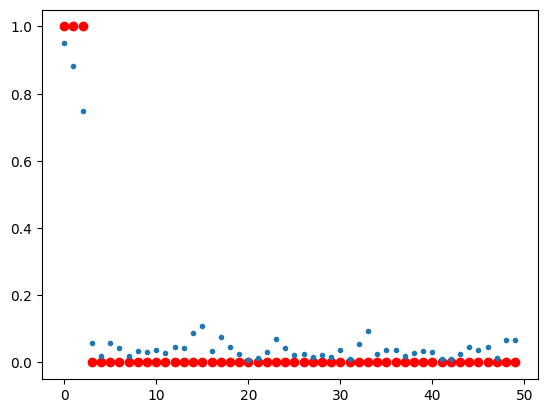

In [300]:
# fig, ax = plt.subplots(1, 2, figsize=(12, 5), layout="tight")

true_gamma = np.zeros(D)
true_gamma[:3] = 1

plt.plot(range(D), true_gamma, 'ro')
# plt.plot(range(D), mean_gammas[2], '.')
plt.plot(range(D), mean_gammas[1/2], '.')

# for lam in [2, 1/100]:
#     ax.scatter(range(D), mean_gammas[lam], s=10, alpha = 0.5)

In [301]:
beta_star.shape

(50,)

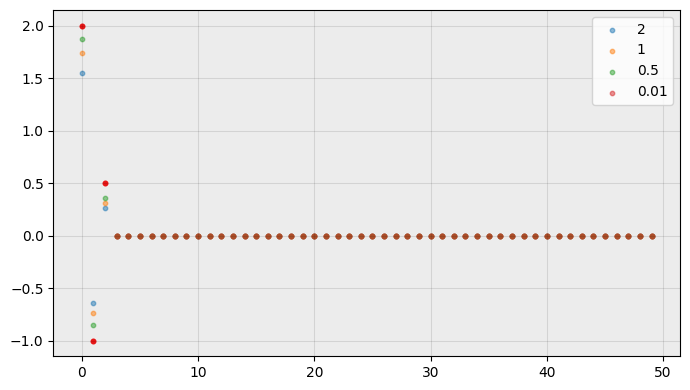

In [302]:
fig, ax = plt.subplots(1, 1, figsize=(7, 4), layout="tight")

ax.set_facecolor("#ECECEC") # set graph background color to grey
ax.grid(visible=True, color="black", alpha=0.1) # add grid lines


beta_star = np.zeros(D)
beta_star[:3] = [2, -1, 0.5]

ax.scatter(range(D), beta_star, color='red', s=10) # plot actual betas
for lam in lams:
    ax.scatter(range(D), mean_betas[lam][1], s=10, alpha=0.5, label=lam)

# add labels to graph
plt.legend()


As $\lambda$ decreases, mean squared error decreases.

Text(0.5, 1.0, 'Mean Squared Error for Different Lambda Values')

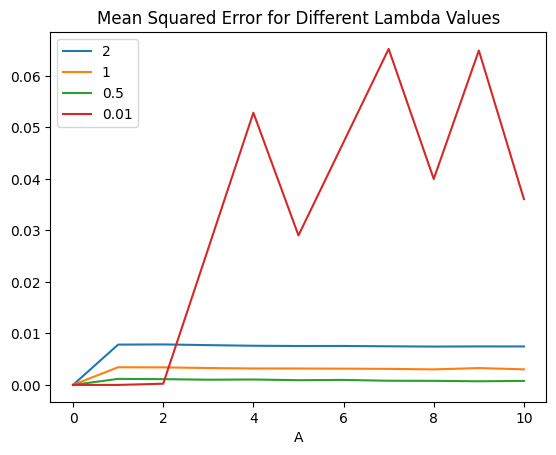

In [303]:
for lam in lams:
    plt.plot(range(len(mean_mse_values[lam])), mean_mse_values[lam], label=f'{lam}')
ax = plt.gca()
plt.legend()
plt.xlabel("A")
plt.title("Mean Squared Error for Different Lambda Values")

As the value of $\lambda$ decreases, the distribution of $\kappa$ values becomes more concentrated around $0$ and $1$.

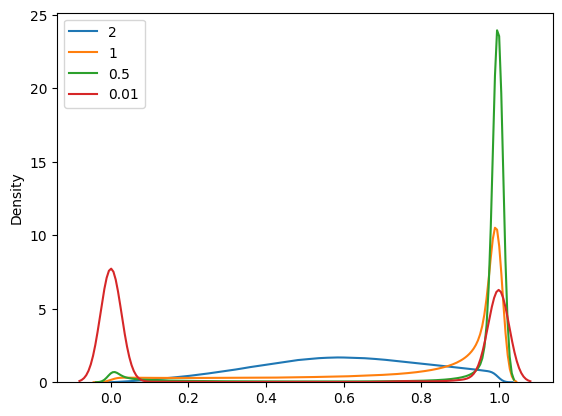

In [304]:
for lam in lams:
    all_kappas[lam] = np.ndarray.flatten(np.array(all_kappas[lam]))
    sns.kdeplot(all_kappas[lam], label=f'{lam}')
plt.legend()